# LeNet

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    # 如果net是一个nn.Module实例,设置为评估模式
    if isinstance(net, torch.nn.Module):
        net.eval()
        # 如果没有提供device,则从第一个参数中获取device
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        # 把数据移到device上
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device) 
        y = y.to(device)
        # 更新metric
        metric.add(d2l.accuracy(net(X), y), y.numel())
    # 返回精度
    return metric[0] / metric[1]

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    # 初始化网络权重
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.xavier_uniform(m.weight)
    net.apply(init_weights)
    print('training on', device)
    # 将网络移动到device
    net.to(device)
    # 定义优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数
    loss = nn.CrossEntropyLoss()
    # 定义动画对象
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])               
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 定义度量对象
        metric = d2l.Accumulator(3)
        # 设置训练模式
        net.train()
        # 迭代训练数据（enumerate()函数可以把一个可迭代对象(如列表、元组、字符串等)组成一个索引序列,使其成为一个索引-值对的迭代器）
        for i, (X, y) in enumerate(train_iter):
            # 记录时间
            timer.start()
            # 清零梯度
            optimizer.zero_grad() 
            # 将数据移动到device
            X, y = X.to(device), y.to(device)
            # 前向传播计算输出
            y_hat = net(X)
            # 计算loss
            l = loss(y_hat, y)
            # 反向传播更新参数
            l.backward()
            optimizer.step()
            # 计算指标
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            # 记录时间
            timer.stop()
            # 计算训练loss和准确率
            train_l = metric[0] / metric[1]
            train_acc = metric[1] / metric[2]
            # 每间隔一定step打印结果
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        # 评估测试集准确率 
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印结果    
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

loss 0.551, train acc 0.829, test acc 0.808
9073.0 examples/sec on cpu


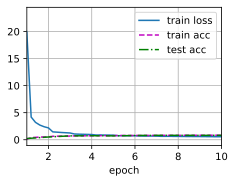

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())